Метод барьерных поверхностей относится к группе методов внутренней точки, т. е. он начинает работать с допустимой точки x0 и генерирует последовательность допустимых точек x1, x2, ..., xn. 

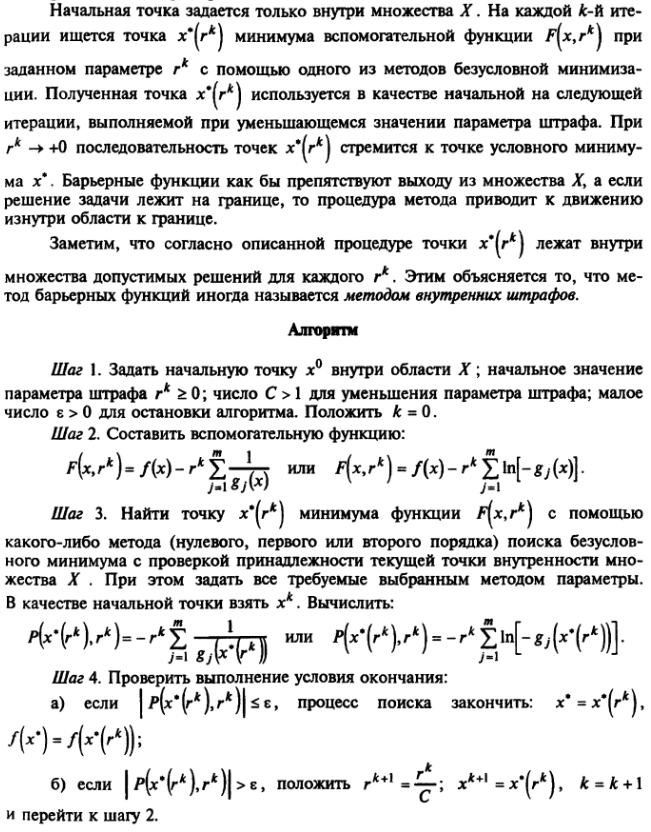

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numdifftools as nd 
from scipy.optimize import minimize_scalar

def fast_descent_method(f, x0, check_restrictions):
    grad = nd.Gradient(f)(x0)
    l, r = 0, 1e9
    
    while r - l > 0.001:
        mid = (r + l) / 2.
        if check_restrictions(x0 - mid * grad):
            l = mid
        else:
            r = mid

    left_border, right_border = 0, l
    if left_border > right_border:
        left_border, right_border = right_border, left_border

    val = minimize_scalar(lambda l: f(x0 - l * grad), bounds=[left_border, right_border], method='bounded').x
    return x0 - val * grad

In [3]:
from prettytable import PrettyTable
import numpy as np

def barrier_functions(f, g, x, penalty_type, r=10, c=12, eps=0.01):
    '''
    f - исследуемая функция
    g - список ограничений-неравенств вида g_i <= 0
    x - начальная точка
    penalty_type - вид штрафной функции
    r (>= 0) - начальное значение параметра штрафа (обычно 1, 10, 100)
    c - число для уменьшения параметра штрафа (обычно 10, 12, 16)
    eps - малое число для остановки алгоритма
    '''
    # для красоты
    table = PrettyTable(['r', 'x_n', 'y_n', 'f(x_n, y_n)', 'F'])
    td = [[r, x[0], x[1], f(x), np.inf]]

    # проверка точки на допустимость
    point_in_set = lambda x: all(func(x) <= 0 for func in g)

    # Составление штрафной функции
    penalty_funcs = {
        'inverse' : lambda f: lambda x: 1/f(x),
        'logarithmic' : lambda f: lambda x: np.log(-f(x))
    }

    penalty_f = lambda r: lambda x: -r * sum(penalty_funcs[penalty_type](f)(x) for f in g)

    while abs(penalty_f(r)(x)) > eps:
        # Составление вспомогательной функции F
        F = lambda x: f(x) + penalty_f(r)(x)
        # Нахождение точки безусловного минимума функции F
        # с проверкой на принадлеждость текущей точки внутренности множества X
        x = fast_descent_method(F, x, point_in_set)
        # Уменьшение значения штрафа
        r /= c

        td.append([r, x[0], x[1], f(x), F(x)])

    for i in range(len(td)):
        table.add_row([round(float(x), 5) for x in td[i]])
    print(table)

    return x

**ПРИМЕР № 1**

In [4]:
f = lambda x: x[0] + x[1]

g1 = lambda x: x[0]**2 - x[1]
g2 = lambda x: -x[0]
g = [g1, g2]

x0 = [1, 4]
eps = 1e-3
r = 1
c = 12

print('С использованием обратной штрафной функции: ')
res1 = barrier_functions(f, g, x0, 'inverse', r, c, eps)
print(f"\nМинимальное значение в точке: ({float(res1[0]):3f}, {float(res1[1]):3f}, {float(f(res1)):3f})\n\n")

print('С использованием логарифмической штрафной функции: ')
res2 = barrier_functions(f, g, x0, 'logarithmic', r, c, eps)
print(f"\nМинимальное значение в точке: ({float(res2[0]):3f}, {float(res2[1]):3f}, {float(f(res2)):3f})")

С использованием обратной штрафной функции: 
+---------+---------+---------+-------------+---------+
|    r    |   x_n   |   y_n   | f(x_n, y_n) |    F    |
+---------+---------+---------+-------------+---------+
|   1.0   |   1.0   |   4.0   |     5.0     |   inf   |
| 0.08333 | 0.49898 | 1.99593 |   2.49491   | 2.70962 |
| 0.00694 | 0.18761 | 1.55861 |   1.74622   |  1.7878 |
| 0.00058 | 0.05572 | 1.39503 |   1.45075   | 1.46155 |
|  5e-05  | 0.01612 | 1.34636 |   1.36248   | 1.36551 |
|   0.0   | 0.00465 | 1.33229 |   1.33694   | 1.33781 |
+---------+---------+---------+-------------+---------+

Минимальное значение в точке: (0.004653, 1.332288, 1.336940)


С использованием логарифмической штрафной функции: 
+---------+---------+---------+-------------+---------+
|    r    |   x_n   |   y_n   | f(x_n, y_n) |    F    |
+---------+---------+---------+-------------+---------+
|   1.0   |   1.0   |   4.0   |     5.0     |   inf   |
| 0.08333 |   0.5   |   3.5   |     4.0     | 3.95954 |

**ПРОВЕРКА**

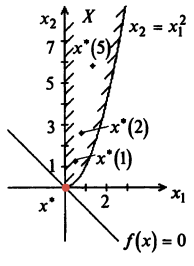

**ПРИМЕР № 2**

In [5]:
f = lambda x : 4*x[0] - x[1]**2 - 12

g1 = lambda x: -x[0] # <= 0
g2 = lambda x: -x[1] # <= 0
g3 = lambda x: - 10*x[0] + x[0]**2 - 10*x[1] + x[1]**2 + 34 # <= 0
g = [g1, g2, g3]

x0 = [5, 4]
eps = 0.05
r = 10
c = 12

print('С использованием обратной штрафной функции: ')
res1 = barrier_functions(f, g, x0, 'inverse', r, c, eps)
print(f"\nМинимальное значение в точке: ({float(res1[0]):3f}, {float(res1[1]):3f}, {float(f(res1)):3f})\n\n")

print('С использованием логарифмической штрафной функции: ')
res2 = barrier_functions(f, g, x0, 'logarithmic', r, c, eps)
print(f"\nМинимальное значение в точке: ({float(res2[0]):3f}, {float(res2[1]):3f}, {float(f(res2)):3f})")

С использованием обратной штрафной функции: 
+---------+---------+---------+-------------+-----------+
|    r    |   x_n   |   y_n   | f(x_n, y_n) |     F     |
+---------+---------+---------+-------------+-----------+
|   10.0  |   5.0   |   4.0   |     -8.0    |    inf    |
| 0.83333 | 3.23169 | 8.28024 |  -67.63565  | -66.88278 |
| 0.06944 |  3.189  | 8.48121 |  -71.17485  | -71.02944 |
| 0.00579 | 3.17742 | 8.53607 |  -72.15477  | -72.11909 |
+---------+---------+---------+-------------+-----------+

Минимальное значение в точке: (3.177423, 8.536068, -72.154770)


С использованием логарифмической штрафной функции: 
+---------+---------+---------+-------------+-----------+
|    r    |   x_n   |   y_n   | f(x_n, y_n) |     F     |
+---------+---------+---------+-------------+-----------+
|   10.0  |   5.0   |   4.0   |     -8.0    |    inf    |
| 0.83333 | 4.25575 |  8.4035 |   -65.5958  | -69.70262 |
| 0.06944 | 4.15217 | 8.86259 |  -73.93686  |  -74.1166 |
| 0.00579 | 4.14301 | 8.9

**ПРОВЕРКА**

In [6]:
from scipy.optimize import minimize, Bounds, NonlinearConstraint
import numpy as np

# ограничения неотрицательности
bounds = Bounds([0,0])

# единственное ограничение
constraints = NonlinearConstraint(
    lambda x: 10*x[0] - x[0]**2 + 10*x[1] - x[1]**2, 34, np.inf
)

res = minimize(
    fun=lambda x: 4*x[0] - x[1]**2 - 12,
    x0=[0,0],
    bounds=bounds,
    constraints=constraints
)
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -74.76561968488801
       x: [ 4.123e+00  8.903e+00]
     nit: 13
     jac: [ 4.000e+00 -1.781e+01]
    nfev: 42
    njev: 13

In [7]:
res.x

array([4.12324937, 8.90273088])